**New York City AirBnb** <br>
Classification: Hotel-priced Airbnb listings<br>
*Bravo, Karba, Kimari, Salsman*

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv(r'https://raw.githubusercontent.com/thomaskarba/MachineLearningSMU/master/AB_NYC_2019.csv')

#preparing data, class
if 'price' in data.columns:
  data['hotel_quality'] = data.price>=300
  data.hotel_quality=data.hotel_quality.astype(np.int)

#removed columns that are not useful 
for item in ['id','last_review','name','price','host_id','host_name']:
  if item in data.columns:
    del data[item]

# imputing reviews_per_month
data = data.transform(lambda grp: grp.fillna(0))  
 
# dummies
if 'burrow_Bronx' not in data.columns:
  burrows = pd.get_dummies(data.neighbourhood_group,prefix='burrow')
  data = pd.concat((data,burrows),axis=1)
if 'hood_Woodside' not in data.columns:
  hood = pd.get_dummies(data.neighbourhood,prefix='hood')
  data = pd.concat((data,hood),axis=1)
if 'type_Private room' not in data.columns:
  roomtype = pd.get_dummies(data.room_type,prefix='type')
  data = pd.concat((data,roomtype),axis=1)  
# removing original dummied features
for item in ['neighbourhood_group','neighbourhood','room_type']:
  if item in data.columns:
    del data[item]
# removing one of dummy variables
if 'burrow_Staten Island' in data:
  del data['burrow_Staten Island']
if 'hood_Allerton' in data:
  del data['hood_Allerton']
if 'type_Shared room' in data:
  del data['type_Shared room']
# reference dummies are burrow:Staten Island, neighborhood: Allerton, room_type: Shared room

data.info(verbose=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 234 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   latitude                         float64
 1   longitude                        float64
 2   minimum_nights                   int64  
 3   number_of_reviews                int64  
 4   reviews_per_month                float64
 5   calculated_host_listings_count   int64  
 6   availability_365                 int64  
 7   hotel_quality                    int64  
 8   burrow_Bronx                     uint8  
 9   burrow_Brooklyn                  uint8  
 10  burrow_Manhattan                 uint8  
 11  burrow_Queens                    uint8  
 12  hood_Arden Heights               uint8  
 13  hood_Arrochar                    uint8  
 14  hood_Arverne                     uint8  
 15  hood_Astoria                     uint8  
 16  hood_Bath Beach                  uint8  
 17  hood_Batter

## Training Test sets

In [ ]:
from sklearn.model_selection import ShuffleSplit

#svm_data = data.sample(10000)

if 'hotel_quality' in data.columns:
  y = data['hotel_quality'].values # get the labels we want
  del data['hotel_quality'] # get rid of the class label
  X = data.values

#if 'hotel_quality' in svm_data.columns:
 # svm_y = svm_data['hotel_quality'].values # get the labels we want
  #del svm_data['hotel_quality'] # get rid of the class label
  #svm_X = svm_data.values

# Test and training split
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

#for train_indices, test_indices in cv_object.split(X,y): 
#    X_train = X[train_indices]
#    y_train = y[train_indices]
#    
#    X_test = X[test_indices]
#    y_test = y[test_indices]

print(cv_object)
#print(len(svm_data))

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


## standardize

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)


#scaler = StandardScaler()
#scaler.fit(svm_X)
#svm_X = scaler.transform(svm_X)

# **Create Models**

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import timeit
# scaled_X helps Logistic Regression


lr_clf = LogisticRegression(penalty='l2', C=2.7, class_weight=None, solver='lbfgs',n_jobs=-1)
acc_list = list()
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(scaled_X,y)):
    lr_clf.fit(scaled_X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(scaled_X[test_indices]) # get test set precitions
    accuracy = mt.accuracy_score(y[test_indices],y_hat) 
    # print the accuracy and confusion matrix 
    print("======Iteration",iter_num,"======",sep='')
    print("accuracy", '%.3f' % accuracy) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
    acc_list.append(accuracy)
print('Mean of Accuracies is %.3f' % np.mean(acc_list))

======Iteration0======
accuracy 0.919
confusion matrix
 [[8950   52]
 [ 738   39]]
======Iteration1======
accuracy 0.922
confusion matrix
 [[8962   53]
 [ 710   54]]
======Iteration2======
accuracy 0.920
confusion matrix
 [[8954   63]
 [ 715   47]]
======Iteration3======
accuracy 0.917
confusion matrix
 [[8919   50]
 [ 764   46]]
======Iteration4======
accuracy 0.918
confusion matrix
 [[8928   63]
 [ 735   53]]
======Iteration5======
accuracy 0.920
confusion matrix
 [[8944   41]
 [ 744   50]]
======Iteration6======
accuracy 0.914
confusion matrix
 [[8891   67]
 [ 778   43]]
======Iteration7======
accuracy 0.919
confusion matrix
 [[8938   57]
 [ 732   52]]
======Iteration8======
accuracy 0.919
confusion matrix
 [[8954   57]
 [ 734   34]]
======Iteration9======
accuracy 0.923
confusion matrix
 [[8963   50]
 [ 707   59]]
Mean of Accuracies is 0.919


Logistic Regression performed well with a mean accuracy of 91.9% for the 10-fold cross validation which is great. Most noteably the cost had to be adjusted to get the best results and the default solver was adequate. We found that scaling the data before fitting the model proved to increase results by a few percent. There were about 800 predictions that were false, but the there really is no rule keeping property listers from disadequately pricing their airbnb based on neighborhood, reviews, etc. 8% false is reasonable.

# Support Vector Machines

In [ ]:
from sklearn import svm
from sklearn import metrics as mt

#scaling X leads to poor performance
svm_clf = svm.SVC(C=1,kernel='sigmoid',gamma='scale') # sigmoid and scale perform the best


acc_list = list()
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    svm_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = svm_clf.predict(X[test_indices]) # get test set precitions
    accuracy = mt.accuracy_score(y[test_indices],y_hat) 
    # print the accuracy and confusion matrix 
    print("======Iteration",iter_num,"======",sep='')
    print("accuracy", '%.3f' % accuracy) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
    acc_list.append(accuracy)
print('Mean of Accuracies is %.3f' % np.mean(acc_list))

======Iteration0======
accuracy 0.879
confusion matrix
 [[8512  480]
 [ 705   82]]
======Iteration1======
accuracy 0.862
confusion matrix
 [[8353  676]
 [ 675   75]]
======Iteration2======
accuracy 0.891
confusion matrix
 [[8622  401]
 [ 668   88]]
======Iteration3======
accuracy 0.883
confusion matrix
 [[8539  457]
 [ 689   94]]
======Iteration4======
accuracy 0.885
confusion matrix
 [[8571  398]
 [ 729   81]]
======Iteration5======
accuracy 0.875
confusion matrix
 [[8494  486]
 [ 737   62]]
======Iteration6======
accuracy 0.888
confusion matrix
 [[8608  412]
 [ 683   76]]
======Iteration7======
accuracy 0.881
confusion matrix
 [[8549  450]
 [ 717   63]]
======Iteration8======
accuracy 0.884
confusion matrix
 [[8577  450]
 [ 683   69]]
======Iteration9======
accuracy 0.863
confusion matrix
 [[8353  651]
 [ 692   83]]
Mean of Accuracies is 0.879


Support Vectors model did similarly to LR with less accuracy yet classified the true positives with greater success. Standardizing data seemed to have a negative effect on the success of the model. The equation for the kernel that yielded the best results was the sigmoid function. Degree and cost had little if any effect on classifications so this was kept at the default. We are confident that this is the best fitting of the data for SVM.

# Model Advantages

The classification problem we are trying to solve is, given the features longitude, latitude, number of reviews, neighbourhood group and so on, can we predict whether renting in an specific area will be good quality? 

Therefore, in order to measure performance, we needed to interpret the accuracy, confusion metric results and the training time.

# **Accuracy** 

The formular for accuracy is True positive + True Negative divide by True positive + True Negative + False positive +False Negatives.

**Logistic Regression**

The Average accuracy for the logistic model is 91%. Which means that on average the model predicted 91 percent True positives and True Negatives.
To get the average accuracy we did a shuffle split with 10 iterations, where our test size was .25. For each iteration we calculated the accuracy and at the end of the itertation we calculated the average accuracy.

We looked closely at the confusion metric and found that the model did not do so well predicting True Positives. lets take one iteration example

accuracy 0.919
confusion metric
 [[8927   53]
 [ 742   57]]

 The test data contains {0: 9669, 1: 110}. 
 
 The model could only predict 57 out of 110 True positives, which is about 51%. 

 We think the reason it did not perform well on the true postives is because we did not have enough data of hotel_quality=1 to train on. In conclusion this model does not predict high quality areas well.


**Support vector**

The Average accuracy for the support vector model is 87 percent. Which mean again on average the model predicted accurately True positives and True Negatives by 87%.

87 percent is not bad for a model but the logistic regression model did better. To understand it clearly lets look at the result for one iteration.

accuracy 0.881
confusion matrix
 [[8553  497]
 [ 664   65]]

The test data contains {0: 9217, 1: 562}. 

On average the model performed poorly on predicting True Positives, but did well on predicting True Negatives. Again we think that the reason it did poorly predicting True positives is because we did not have enough data of hotel_quality=1 to train on



# **Training Time or Efficiency**

The logistic regression model took 3 mins to go through 10 iterations  and the support vector model took 25 minutes. Clearly The support vector took the longest time and it did't perform better than the logistic regression model. We think the reason the support vector model took long is because we have a high dimensional  dataset.

# Conclusion 

The Advantages of logistic regression is that it goes through the iterations in less time than Support Vector model and it does very well in predicting considering accuracy. The SVM just performed a marginally better true prediction of True Positives but suffered for negatives.

The superior model between the two model is Logistic regression in accuracy and efficiency


# Interpret Feature Importance

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,data.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

longitude has weight of -0.6773274027751802
number_of_reviews has weight of -0.4498797724673506
hood_Jackson Heights has weight of -0.3521553912807597
minimum_nights has weight of -0.343070886486716
hood_Midwood has weight of -0.285201907256033
hood_Maspeth has weight of -0.280708269739379
hood_Bensonhurst has weight of -0.2621488901954941
hood_Roosevelt Island has weight of -0.2546790952394361
hood_Brighton Beach has weight of -0.2500298728259655
hood_Fort Hamilton has weight of -0.24716967721974317
hood_Fordham has weight of -0.2270842505883614
hood_Tompkinsville has weight of -0.2172177204761343
hood_Woodhaven has weight of -0.20874848518317335
hood_Concourse has weight of -0.2037706997913589
hood_Ozone Park has weight of -0.19927840088910795
hood_Port Morris has weight of -0.19831177531322466
hood_Glendale has weight of -0.18946151427130836
hood_Washington Heights has weight of -0.18529578755737086
hood_Randall Manor has weight of -0.1728448904389191
hood_Harlem has weight of -0.16

In logistic binary regression the weights are equal to our model's coefficients. Negative weights are associated with an increase in likelihood that the place will be classified as 'low' price. Positive is associated with 'high' price. The coninuous variables; minimum_nights, availability_365, number_of_reviews, reviews_per_month, can be interpreted as a one unit change to these variables is associated that weight's change in probability. For example, number_of_reviews has a weight of -0.45, meaning that with each extra review the probability of being classified as "high" price goes down .45. The categorical variables are all interpreted in reference to the reference variable chosen. For instance, Staten Island is the reference borough, and Manhattan has a weight of .068. This means that if a place is in Manhattan it has a 6.8% better chance of being classified as 'high' price than a if that place was in the reference borough of Staten Island. This makes sense since Manhattan is a more desirable tourist borough and most people using Airbnb are tourists.


The weights from Logistic Regression classifier of the standardized data shows that the room type 'Entire home/apt' holds the greatest weight. This is not surprising as we expect people to pay more for bigger places. The classifier Longitude was also a big determinant in the classifier. Third most important is availability_365. While these features are the most important the weights included are all in a similar range (within .1-.3) so we do not recommend removing any of the continuous features. The neighborhoods have perhaps the least bearing on the classification, many less than a tenth, the highest .28, on the lowest end of importance. You could make a case that neighborhoods should be removed but they are geographic as longitude is, which is important. If this model were to be finalized neighborhoods would be removed as they may be correlated to longitude/latitude which would also help make the model simpler. Another reason to remove neighborhoods is that because there are so many neighborhoods as separate dummy variables the sample size per class may be much smaller and prove difficult for the model to weigh a classification. Representation of instances per neighborhood class in the test and training set, though even may offer an imbalanced interpretation. One argument to keep neighborhoods is that some neighborhood like Midtown and Midwood have a much higher weight than other neighborhoods and could be useful in classification.
What these features are telling us is that the pricing of an average price of a hotel or hotel_quality listing is determined largely on the size of space alotted in the listing as well as how available a listing is will determine it to be higher priced. Longitude is also important as it has the better measure of closeness to NYC as it is more vertical to diagonal in geographic terms.

# Interpret Support Vectors

In [ ]:

df_tested_on = data.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()
df_support['hotel_quality'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
data['hotel_quality'] = y # also add it back in for the original data
df_support.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5727 entries, 2840 to 14305
Columns: 234 entries, latitude to hotel_quality
dtypes: float64(3), int64(5), uint8(226)
memory usage: 1.6 MB


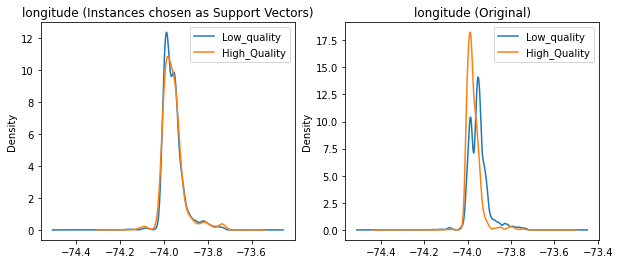

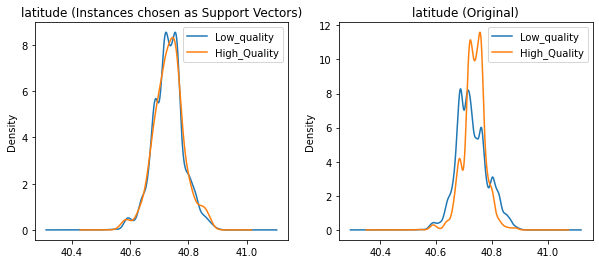

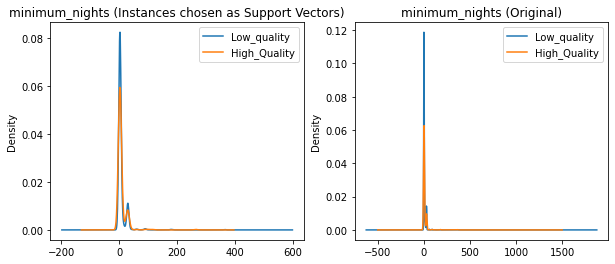

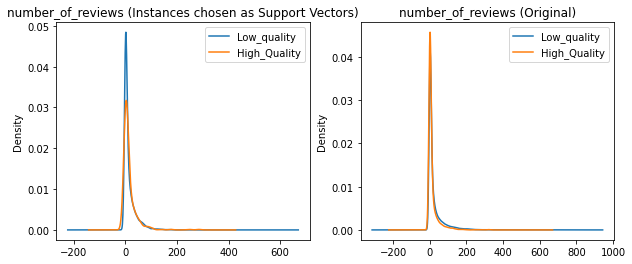

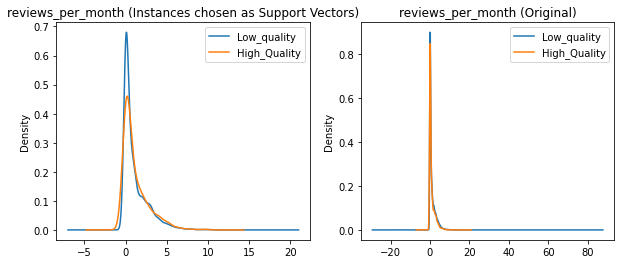

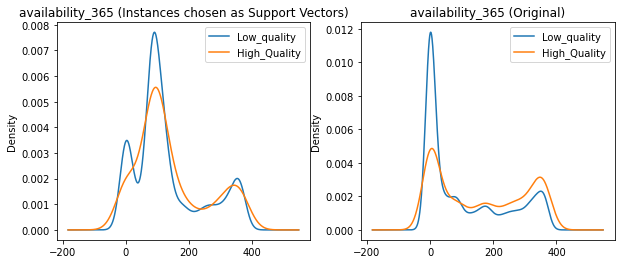

In [ ]:
from pandas.plotting import boxplot
from matplotlib import pyplot as plt# group the original data and the support vectors
df_grouped_support = df_support.groupby(['hotel_quality'])
df_grouped = data.groupby(['hotel_quality'])# plot KDE of Different variables
vars_to_plot = ['longitude','latitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month','availability_365']
for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde()
    plt.legend(['Low_quality','High_Quality'])
    plt.title(v+' (Instances chosen as Support Vectors)')    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde()
    plt.legend(['Low_quality','High_Quality'])
    plt.title(v+' (Original)')



**Interpretion on the Support Vector**


The whole concept of support vectors is finding thresholds to classify dependent binary variables. This helps us focus on the instances for each cluster. The  above plots illustrate the statistical analysis between the orginal data and the support vector data. The reason why the distributions for the support between low and high quality is not separated is because support vectors allow for some misclassification. Which means that if a low quality instance pass the threshold and is found in high quality region, then the model will classify it as high quality. We think thats why the support vector did not do as well in predicting true negatives than the logistic regression. Another reason the svm model may not have been as great is the original high/low separations of the variables. For many of these variables, the original distributions do not offer much separation for our svm hyperplane to be able to separate on despite its best efforts. 